### Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


# Process

### Data Import

In [2]:
df = pd.read_csv("../Data/merged.csv")

In [3]:
# Using only top 4000 rows due to compuation
df = df[:4000]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             4000 non-null   object 
 1   rideable_type       4000 non-null   object 
 2   started_at          4000 non-null   object 
 3   ended_at            4000 non-null   object 
 4   start_station_name  3381 non-null   object 
 5   start_station_id    3381 non-null   object 
 6   end_station_name    4000 non-null   object 
 7   end_station_id      4000 non-null   object 
 8   start_lat           4000 non-null   float64
 9   start_lng           4000 non-null   float64
 10  end_lat             4000 non-null   float64
 11  end_lng             4000 non-null   float64
 12  member_casual       4000 non-null   object 
dtypes: float64(4), object(9)
memory usage: 406.4+ KB


### Calculate ride length

In [4]:
date_format = '%Y-%m-%d %H:%M:%S'
ride_format = '%H:%M:%S'

# Convert strings to datetime
df['started_at'] = pd.to_datetime(df['started_at'],format=date_format)
df['ended_at'] =  pd.to_datetime(df['ended_at'],format=date_format)

# Calculate the time difference and store it in a new column
df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

# Convert to seconds to ride_format
df['ride_length'] = df['ride_length'].apply(lambda x: f'{int(x // 3600)}:{int((x % 3600) // 60)}:{int(x % 60)}')

Example

In [5]:
df['ride_length'].head()

0    0:10:51
1     0:8:29
2    0:13:14
3     0:8:46
4    0:15:19
Name: ride_length, dtype: object

### Calculate day of the week ride started
1 = monday, 7 = sunday

In [6]:
df['day_of_week'] = df['started_at'].dt.day_name()

Example

In [7]:
df['day_of_week'].head()

0    Saturday
1     Tuesday
2      Monday
3      Sunday
4    Thursday
Name: day_of_week, dtype: object

# Analyze

### Clean Data

In [8]:
# Drop null or na rows
df = df.dropna()

# Now null rows
df.isna().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_length           0
day_of_week           0
dtype: int64

### Descriptive Analysis

In [9]:
# Convert ride_length to timedelta format
df['ride_length_seconds'] = pd.to_timedelta(df['ride_length'])

# Convert ride_length to seconds
df['ride_length_seconds'] = df['ride_length_seconds'].dt.total_seconds()
df = df[df['ride_length_seconds']<10000]

# Calculate mean and max ride_length in seconds
mean_ride_length_seconds = df['ride_length_seconds'].mean()
max_ride_length_seconds = df['ride_length_seconds'].max()

# Convert mean and max ride_length back to '%H:%M:%S' format for better readability
mean_ride_length = pd.to_timedelta(mean_ride_length_seconds, unit='seconds',)
max_ride_length = pd.to_timedelta(max_ride_length_seconds, unit='seconds')

# Calculate mode of day_of_week
mode_day_of_week = df['day_of_week'].mode().values[0]

print("Mean ride length:", mean_ride_length)
print("Max ride length:", max_ride_length)
print("Mode day of week:",mode_day_of_week)

Mean ride length: 0 days 00:09:52.373925926
Max ride length: 0 days 02:39:53
Mode day of week: Tuesday


### Pivot Tables

In [10]:
# Function to convert seconds to HH:MM:SS format
def convert_seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

In [11]:
# pivot table with mean ride length in seconds for members and casual riders
pivot_table_1_seconds = df.pivot_table(values='ride_length_seconds', index='member_casual', aggfunc=np.mean)

# pivot table with mean ride length in seconds for users by day_of_week
pivot_table_2_seconds = df.pivot_table(values='ride_length_seconds', index='member_casual', columns='day_of_week', aggfunc=np.mean)

# Convert pivot_tables_seconds values to HH:MM:SS format
pivot_table_1 = pivot_table_1_seconds.applymap(convert_seconds_to_time)
pivot_table_2 = pivot_table_2_seconds.applymap(convert_seconds_to_time)

print(pivot_table_1)
print("-"*100)
print(pivot_table_2)

              ride_length_seconds
member_casual                    
casual                   00:12:12
member                   00:09:15
----------------------------------------------------------------------------------------------------
day_of_week      Friday    Monday  Saturday    Sunday  Thursday   Tuesday  \
member_casual                                                               
casual         00:11:59  00:13:16  00:11:19  00:15:50  00:07:26  00:12:40   
member         00:08:21  00:09:13  00:08:31  00:10:58  00:08:34  00:09:09   

day_of_week   Wednesday  
member_casual            
casual         00:12:11  
member         00:10:07  


# Visualizations

### Histogram of ride lengths for members and casual riders

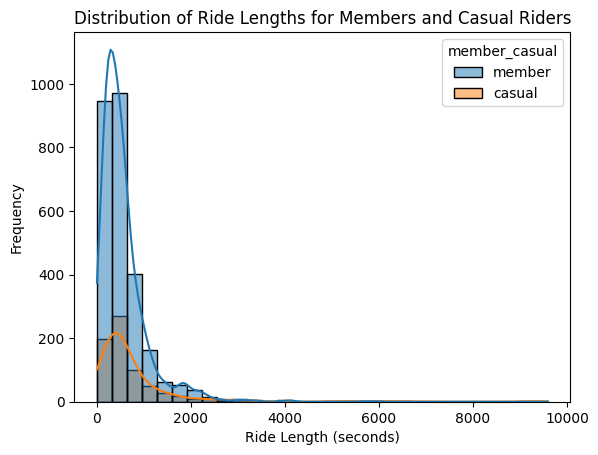

In [23]:
sns.histplot(data=df, x='ride_length_seconds', hue='member_casual', bins=30,kde=True)  # Adjust bins and range
plt.title('Distribution of Ride Lengths for Members and Casual Riders')
plt.xlabel('Ride Length (seconds)')
plt.ylabel('Frequency')
plt.show()

### Weekly ride count over time for different user types

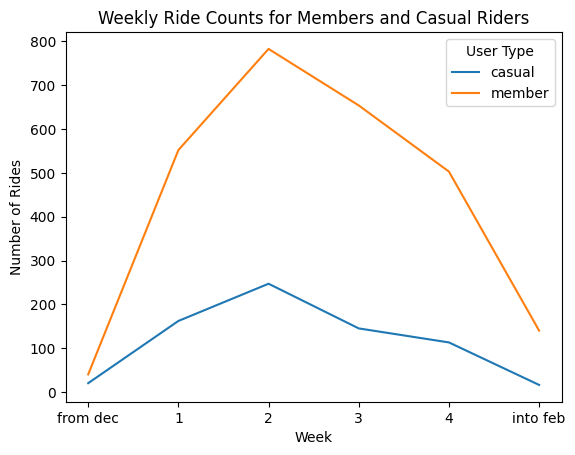

In [21]:
df['week_start'] = df['started_at'].dt.to_period('W').dt.start_time
weekly_ride_counts = df.groupby(['week_start', 'member_casual']).size().unstack()
weekly_ride_counts
weekly_ride_counts.index = ['from dec',1,2,3,4,'into feb']
weekly_ride_counts.plot(kind='line')

plt.title('Weekly Ride Counts for Members and Casual Riders')
plt.xlabel('Week')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.show()

### K-Means clustering for user segmentation based on ride behavior

In [14]:
# Considering only numeric columns for clustering
cluster_data = df[['ride_length_seconds', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data)

customer_segments = df['cluster'].value_counts()
customer_segments.index = ['Casual riders','Moderate riders','Long dist riders']

/home/atesam/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
customer_segments

Casual riders       2949
Moderate riders      409
Long dist riders      17
Name: cluster, dtype: int64

### 3D scatter plot for three selected features colored by clusters


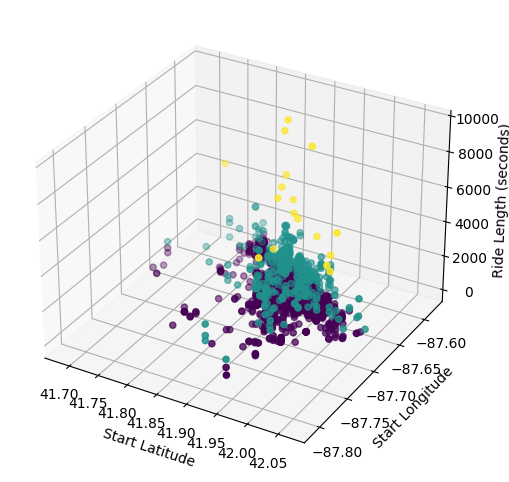

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['start_lat'], df['start_lng'], df['ride_length_seconds'], c=df['cluster'], cmap='viridis')
ax.set_xlabel('Start Latitude')
ax.set_ylabel('Start Longitude')
ax.set_zlabel('Ride Length (seconds)')
plt.show()

### Correlation matrix heatmap

/tmp/ipykernel_7438/943108700.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


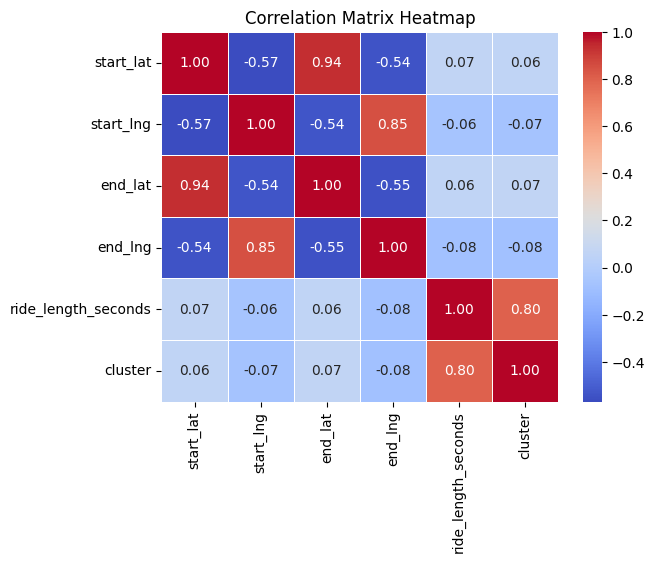

In [17]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Line plot of ride count by day of the week for different user types


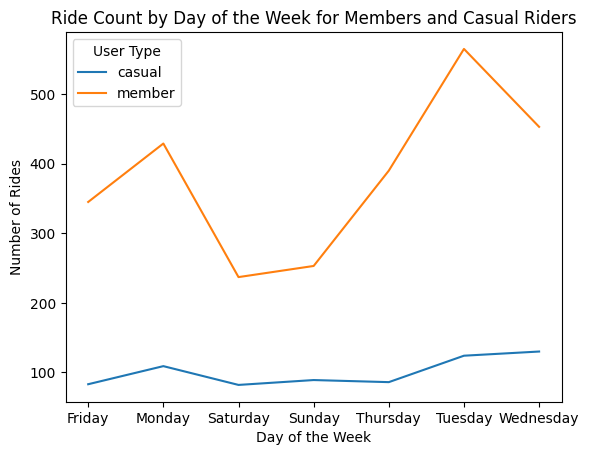

In [18]:
ride_counts_by_day = df.groupby(['day_of_week', 'member_casual']).size().unstack().fillna(0)
ride_counts_by_day.plot(kind='line')
plt.title('Ride Count by Day of the Week for Members and Casual Riders')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.show()


### Bar plot for rideable type distribution

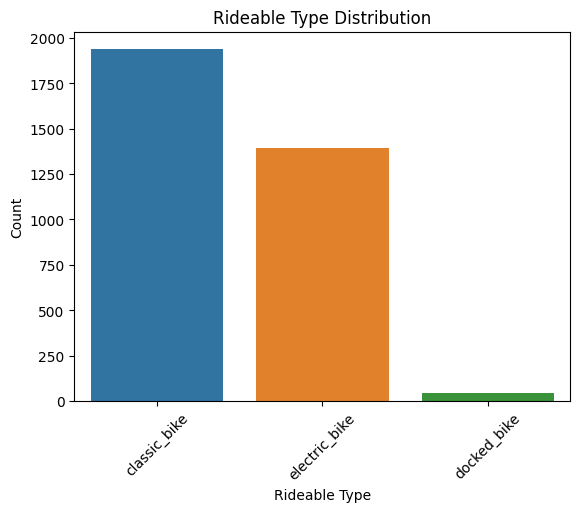

In [20]:
rideable_counts = df['rideable_type'].value_counts()
sns.barplot(x=rideable_counts.index, y=rideable_counts.values)
plt.title('Rideable Type Distribution')
plt.xlabel('Rideable Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()